In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Data/Faces.zip

Archive:  /content/drive/MyDrive/Data/Faces.zip
   creating: Faces/
  inflating: Faces/rename.py         
   creating: Faces/WiderSelected/
  inflating: Faces/WiderSelected/annotations.txt  
  inflating: Faces/WiderSelected/README.md  
   creating: Faces/WiderSelected/train/
   creating: Faces/WiderSelected/train/0--Parade/
  inflating: Faces/WiderSelected/train/0--Parade/0.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/1.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/10.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/11.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/12.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/13.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/14.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/15.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/16.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/17.jpg  
  inflating: Faces/WiderSelected/train/0--Parade/18.jpg  
  inflating: Faces/WiderSelected/train

In [ ]:
# Required Packages

import matplotlib.pyplot as plt
import numpy as np
from numpy import expand_dims
import cv2
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

import random
import os

In [ ]:
data_name = "Faces/WiderSelected"

In [ ]:
# Reading from the dataset and resizing each face and its landmarks

os.chdir("/content/%s/"%data_name)

new_heigth, new_width = 256, 256
new_ann = open("./annotations.txt", "r")

lines = new_ann.readlines()

pointer = 0

input_data = []
labels = []
pbar = tqdm(total=4275)
while pointer != len(lines):
    path = lines[pointer][:-1]
    os.chdir("/content/Faces")
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    cur_heigth, cur_width = image.shape
    pointer += 1
    n = int(lines[pointer])
    pointer += 1
    
    for i in range(n):
        temp = lines[pointer].split()
        temp = [int(t) for t in temp]
        x, y, w, h = temp[0], temp[1], temp[2], temp[3]
        landmarks = temp[4:]

        face_img = image[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (new_width, new_heigth), fx=(new_width/w), fy=(new_heigth/h), interpolation=cv2.INTER_CUBIC)
        input_data.append(face_img)
        
        temp = []
        for j in range(0, len(landmarks), 2):
            x_l, y_l = landmarks[j], landmarks[j + 1]
            x_l, y_l = x_l - x, y_l - y
            x_l, y_l = x_l * new_width // w, y_l * new_heigth // h
            temp.append([x_l, y_l])
        labels.append(temp)
        pointer += 1
    pbar.update(1)

pbar.close()
new_ann.close()


  0%|          | 0/4275 [00:29<?, ?it/s]

100%|██████████| 4275/4275 [00:25<00:00, 166.44it/s]


In [ ]:
# Count of faces

len(labels)

6249

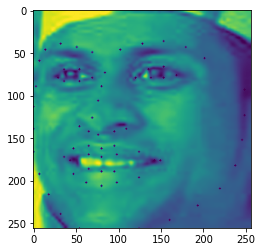

In [ ]:
# Presenting a random resized image in the dataset

index = random.randint(0, (len(input_data) - 1))
image = input_data[index]
landmarks = labels[index]


for i in range(0,len(landmarks)):
    x, y = landmarks[i]
    image = cv2.circle(image, (x, y), radius=1, color=(0, 0, 255), thickness=-1)

plt.imshow(image)
plt.show()

In [ ]:
import numpy as np

input_data = np.array(input_data)
input_data.shape = input_data.shape[0], new_heigth, new_width, 1
labels = np.array(labels)

print(input_data.shape)
print(labels.shape)

(6249, 256, 256, 1)
(6249, 68, 2)


In [ ]:
# Norm X
norm_train_images = input_data/255

# Norm Y
norm_labels = labels / 256
# Train Test split

train_percent = 0.8
X_train = norm_train_images[:int(train_percent * norm_train_images.shape[0]), :, :]
X_test = norm_train_images[int(train_percent * norm_train_images.shape[0]):, :, :]
Y_train = norm_labels[:int(train_percent * norm_train_images.shape[0]), :, :]
Y_test = norm_labels[int(train_percent * norm_train_images.shape[0]):, :, :]


# CNN
first_filters = 64
second_filters = 98
third_filters = 136

kernel_size = (3,3)
pool_size = (2,2)


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation="relu", input_shape=(256, 256, 1)))
model.add(Conv2D(first_filters, kernel_size, activation="relu"))
model.add(Conv2D(first_filters, kernel_size, activation="relu"))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(second_filters, kernel_size, activation="relu"))
model.add(Conv2D(second_filters, kernel_size, activation="relu"))
model.add(Conv2D(second_filters, kernel_size, activation="relu"))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(third_filters))
model.add(Activation("sigmoid"))
model.add(Reshape((68, 2)))

os.chdir("/content/drive/MyDrive/Weights")
checkpoint = ModelCheckpoint("lm_det.h5", monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)

model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              metrics=["mse"])

history = model.fit(X_train,Y_train, epochs=5, batch_size=32, validation_data=(X_test,Y_test), callbacks=[checkpoint])

Epoch 1/5
157/157 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0060
Epoch 1: val_loss improved from inf to 0.00364, saving model to lm_det.h5
157/157 [==============================] - 100s 512ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/5
157/157 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022
Epoch 2: val_loss improved from 0.00364 to 0.00206, saving model to lm_det.h5
157/157 [==============================] - 83s 531ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/5
157/157 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017
Epoch 3: val_loss improved from 0.00206 to 0.00188, saving model to lm_det.h5
157/157 [==============================] - 83s 527ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/5
157/157 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014
Epoch 4: val_loss improved from 0.001

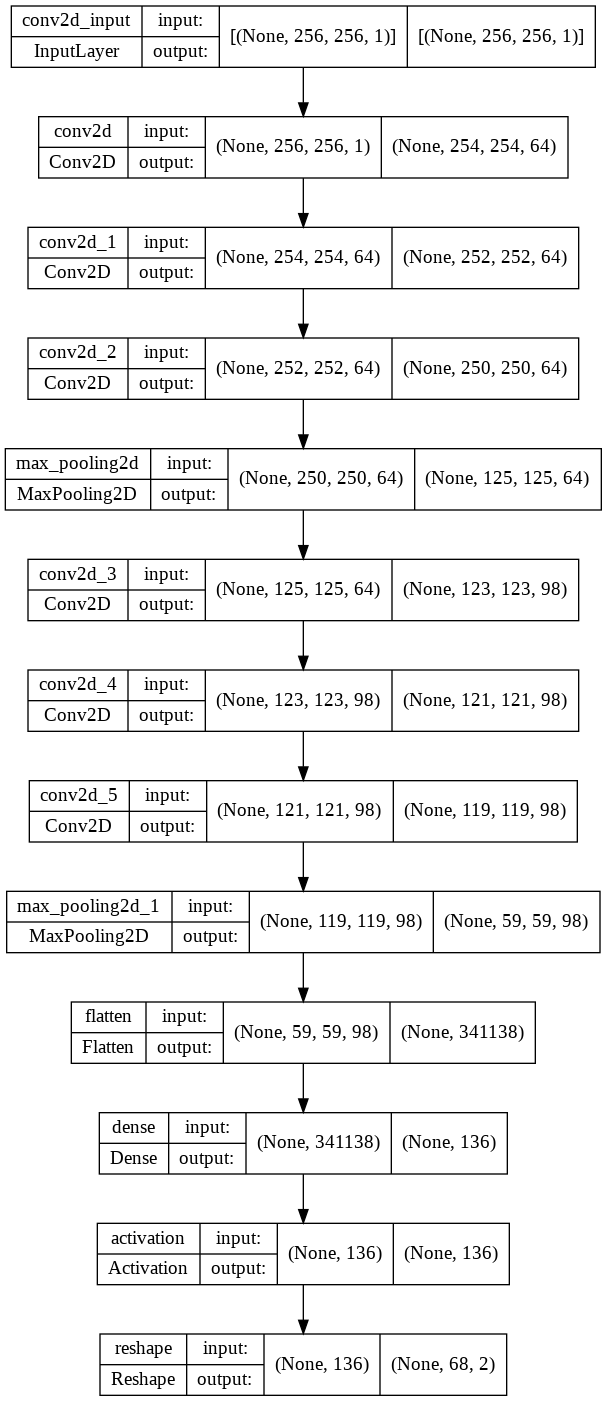

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

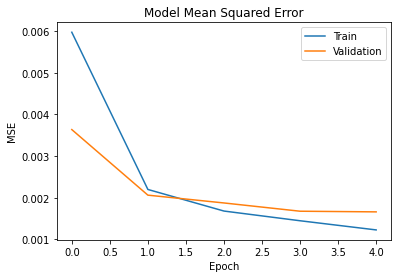

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])#, loc='upper left')
plt.show()

In [ ]:
def visualise_pts(img, pts, title_num=0):
    plt.rcParams['figure.figsize'] = [5, 5]
    titles = ["Ground Truth Points", "Predictions"]
    img.shape = new_heigth, new_width
    plt.imshow(img)
    plt.plot(pts[:, 0], pts[:, 1], '+r')
    plt.title(titles[title_num])
    plt.show()

In [ ]:
predictions = model.predict(X_test) 
predictions *= 256

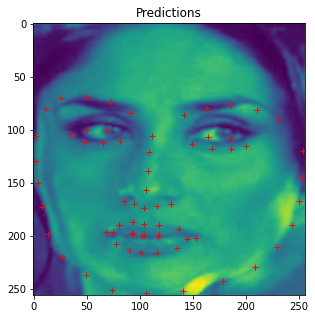

In [ ]:
for i in range(20,21):
    visualise_pts(X_test[i, ...], predictions[i, ...],1)

In [ ]:
def read_image(directory, start, end):

    index = random.randint(start, end)
    # index = 1

    os.chdir("/content/%s/"%data_name)

    new_heigth, new_width = 256, 256
    new_ann = open("./annotations.txt", "r")

    lines = new_ann.readlines()

    pointer = 0

    faces = []


    while pointer != len(lines):
        path = lines[pointer][:-1]
        if path != "/content/%s/train/%s/%d.jpg"%(data_name, directory, index):
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            for i in range(n):
                pointer += 1
        else:
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            os.chdir("/content/Faces")
            image_colored = cv2.imread(path)
            cur_heigth, cur_width = image.shape
            pointer += 1
            n = int(lines[pointer])
            pointer += 1
            boxes = []
            for i in range(n):
                temp = lines[pointer].split()
                temp = [int(t) for t in temp]
                x, y, w, h = temp[0], temp[1], temp[2], temp[3]
                boxes.append([x, y, w, h])
                face_img = image[y:y+h, x:x+w]
                face_img = cv2.resize(face_img, (new_width, new_heigth), 
                                      fx=(new_width/w), fy=(new_heigth/h), 
                                      interpolation=cv2.INTER_CUBIC)
                faces.append(face_img)

                pointer += 1


    new_ann.close()
    return faces, image_colored, boxes

In [ ]:
def show_image(image, boxes, predicted):
    plt.rcParams['figure.figsize'] = [10, 10]
    for i in range(faces.shape[0]):
        landmarks = predicted[i, :, :].copy()
        temp = []
        x, y, w, h = boxes[i]
        for j in range(0, landmarks.shape[0]):
            x_l, y_l = landmarks[j, :].copy()
            x_l, y_l = x_l * w // new_width, y_l * h // new_heigth
            x_l, y_l = x_l + x, y_l + y
            plt.plot(x_l, y_l, '.r')
    plt.imshow(image)
    plt.show()

In [ ]:
# An image from the dataset

directory = "1--Handshaking"
start, end = 65, 99

faces, image, boxes = read_image(directory, start, end)
image = image[:, :, ::-1]
faces = np.array(faces)
faces.shape = faces.shape[0], faces.shape[1], faces.shape[1], 1
faces = faces / 255
predicted = model.predict(faces)
predicted *= 256
print(faces.shape)
print(predicted.shape)
show_image(image, boxes, predicted)

UnboundLocalError: ignored

(1, 256, 256, 1)
(1, 68, 2)


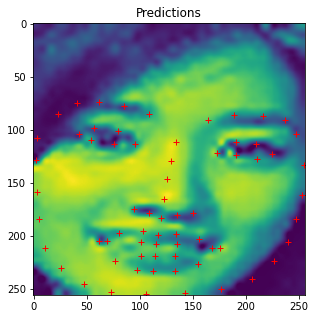

In [ ]:
path = "/content/test.jpg"


image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image_colored = cv2.imread(path)
image = cv2.resize(image, (200, 200), interpolation=cv2.INTER_CUBIC)
# test = [[77, 19, 38, 37]]
# brown = [[67, 34, 64, 68]]
# h = [[131, 46, 23, 66], [172, 10, 21, 48]]
# me = [[68, 61, 56, 61]]
boxes = [[77, 19, 38, 37]]
faces = []
for box in boxes:
  x, y, w, h = box
  face_img = image[y:y+h, x:x+w]
  face_img = cv2.resize(face_img, (new_width, new_heigth), 
                        fx=(new_width/w), fy=(new_heigth/h), 
                        interpolation=cv2.INTER_CUBIC)
  faces.append(face_img)
faces = np.array(faces)
faces.shape = faces.shape[0], faces.shape[1], faces.shape[1], 1
faces = faces / 255
predicted = model.predict(faces)
predicted *= 256
print(faces.shape)
print(predicted.shape)

for i in range(faces.shape[0]):
  visualise_pts(faces[i, ...], predicted[i, ...],1)